In [1]:
# Block 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from PyMPDATA import Options, Stepper, Solver, ScalarField, VectorField
from PyMPDATA.boundary_conditions import Periodic

In [2]:
# Configure PyMPDATA options for 1D advection
opts = Options(n_iters=2, infinite_gauge=True, nonoscillatory=True)  # 2 iterations for 2nd-order accuracy

# Define domain and simulation parameters
Lx = 1000.0       # domain length in arbitrary units (e.g., 0 to 1000)
Nx = 1000         # number of grid cells
dx = Lx / Nx      # grid spacing
x = np.linspace(0, Lx, Nx, endpoint=False)  # cell-center coordinates
c = 1.0           # advection speed (units of length per time)
dt = 1.0          # time step size (e.g., 1 second)
omega = 2 * np.pi / 400.0  # oscillator frequency (one period = 400 time units):contentReference[oaicite:4]{index=4}

# Total simulation time and steps
T = 1400.0        # total simulated time (e.g., 1400 s)
n_steps = int(T / dt)
print(f"Grid: {Nx} points, dx={dx}. dt={dt}, steps={n_steps}, c={c}, omega={omega:.4f}")


Grid: 1000 points, dx=1.0. dt=1.0, steps=1400, c=1.0, omega=0.0157


In [3]:
# Block 2: Initial Conditions
# Define a raised cosine bump for psi between x=50 and x=150, zero elsewhere
psi0 = np.zeros(Nx)
mask = (x >= 50) & (x <= 150)
# Cosine bump: psi = 0.5 * [1 + cos(pi * (x - center)/width)] within the interval
psi0[mask] = 0.5 * (1 + np.cos(np.pi * (x[mask] - 100) / 50))
psi0_max = psi0.max()
psi0 /= psi0_max   # normalize peak to 1.0 for convenience
phi0 = np.zeros(Nx)

print(f"Initial psi peak = {psi0.max():.2f} at x ~{x[np.argmax(psi0)]}, phi everywhere = {phi0.min():.1f}")


Initial psi peak = 1.00 at x ~100.0, phi everywhere = 0.0


In [4]:
# Block 3: Solver Setup (Stepper, Fields, Advector)
# Create a Stepper for 1D advection with the specified options
stepper = Stepper(options=opts, n_dims=1)

# Initialize ScalarField objects for psi and phi, including halo for boundary conditions
halo = stepper.options.n_halo  # number of halo points required by scheme
bc = (Periodic(), Periodic())  # periodic BC at domain start and end
psi_field = ScalarField(data=psi0, halo=halo, boundary_conditions=bc)
phi_field = ScalarField(data=phi0, halo=halo, boundary_conditions=bc)

# Set up the constant velocity field as a VectorField.
# For 1D, advector data is a tuple with one numpy array (velocity in x-direction).
# We fill it with the constant c at all staggered points (length Nx+1 for periodic domain).
u = np.full(Nx+1, c)
u_field = VectorField(data=(u,), halo=halo, boundary_conditions=bc)

# Create Solver instances for psi and phi using the same stepper and velocity field
solver_psi = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
solver_phi = Solver(stepper=stepper, advectee=phi_field, advector=u_field)


In [5]:
# Block 4: Simulation Loop – Explicit Euler Coupling
# Reset fields to initial state
psi_field.get()[:] = psi0  # note: use .get() to access the data array without halos
phi_field.get()[:] = phi0

# Time integration with explicit Euler coupling
for n in range(n_steps):
    psi_old = psi_field.get().copy()
    phi_old = phi_field.get().copy()
    # Advect psi and phi one step (MPDATA handles the advection)
    solver_psi.advance(1)
    solver_phi.advance(1)
    # After this, psi_field and phi_field contain advected values (psi*, phi*)
    psi_adv = psi_field.get()
    phi_adv = phi_field.get()
    # Explicit Euler coupling update
    psi_field.get()[:] = psi_adv + dt * omega * phi_old    # ψ^{n+1}
    phi_field.get()[:] = phi_adv - dt * omega * psi_old    # φ^{n+1}

# Store results for analysis
psi_explicit = psi_field.get().copy()
phi_explicit = phi_field.get().copy()
print("Explicit coupling simulation finished.")


Explicit coupling simulation finished.


In [6]:
# Block 5: Simulation Loop – Semi-Implicit Trapezoidal Coupling
# Reset fields to initial state
psi_field.get()[:] = psi0
phi_field.get()[:] = phi0

# Time integration with trapezoidal (semi-implicit) coupling via Strang splitting
for n in range(n_steps):
    psi_old = psi_field.get().copy()
    phi_old = phi_field.get().copy()
    # Half-step explicit coupling
    psi_half = psi_old + 0.5 * dt * omega * phi_old
    phi_half = phi_old - 0.5 * dt * omega * psi_old
    psi_field.get()[:] = psi_half
    phi_field.get()[:] = phi_half
    # Advect over full step with MPDATA
    solver_psi.advance(1)
    solver_phi.advance(1)
    # After advection, get intermediate fields (denoted with * or "half" advected)
    psi_star = psi_field.get().copy()
    phi_star = phi_field.get().copy()
    # Second half-step explicit coupling
    psi_field.get()[:] = psi_star + 0.5 * dt * omega * phi_star
    phi_field.get()[:] = phi_star - 0.5 * dt * omega * psi_star

# Store results for analysis
psi_trapez = psi_field.get().copy()
phi_trapez = phi_field.get().copy()
print("Trapezoidal coupling simulation finished.")


Trapezoidal coupling simulation finished.


<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\szymo\AppData\Local\Temp\ipykernel_32576\1162246013.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x, psi_explicit, 'b-', label='$\psi$ (explicit)')
C:\Users\szymo\AppData\Local\Temp\ipykernel_32576\1162246013.py:7: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(x, phi_explicit, 'r--', label='$\phi$ (explicit)')
C:\Users\szymo\AppData\Local\Temp\ipykernel_32576\1

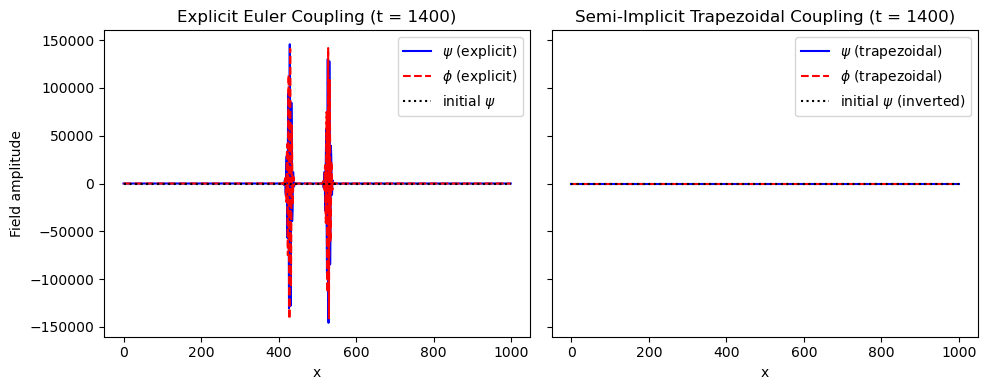

In [7]:
# Block 6: Visualization of Results
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Explicit Euler results
ax = axes[0]
ax.plot(x, psi_explicit, 'b-', label='$\psi$ (explicit)')
ax.plot(x, phi_explicit, 'r--', label='$\phi$ (explicit)')
ax.plot(x, psi0, 'k:', label='initial $\psi$')
ax.set_title("Explicit Euler Coupling (t = 1400)")
ax.set_xlabel("x")
ax.set_ylabel("Field amplitude")
ax.legend(loc="upper right")

# Trapezoidal results
ax = axes[1]
ax.plot(x, psi_trapez, 'b-', label='$\psi$ (trapezoidal)')
ax.plot(x, phi_trapez, 'r--', label='$\phi$ (trapezoidal)')
ax.plot(x, -psi0, 'k:', label='initial $\psi$ (inverted)')
ax.set_title("Semi-Implicit Trapezoidal Coupling (t = 1400)")
ax.set_xlabel("x")
ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("oscillator_explicit_vs_trapez.png")
plt.show()


In [8]:
# Block 7: Wrap the two runs in a function for easy testing
def run_oscillator_simulation():
    """
    Runs both the explicit-Euler and trapezoidal coupling schemes,
    returns (psi0, psi_explicit, phi_explicit, psi_trapez, phi_trapez).
    """
    # reuse psi0, phi0, stepper, u_field, etc., from previous blocks
    
    # --- Explicit Euler ---
    psi_field.get()[:] = psi0
    phi_field.get()[:] = phi0
    for _ in range(n_steps):
        s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
        s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)
        s1.advance(1); s2.advance(1)
        po = psi_field.get().copy(); fo = phi_field.get().copy()
        psi_field.get()[:] += dt * omega * fo
        phi_field.get()[:] -= dt * omega * po
    psi_ex = psi_field.get().copy()
    phi_ex = phi_field.get().copy()
    
    # --- Trapezoidal ---
    psi_field.get()[:] = psi0
    phi_field.get()[:] = phi0
    for _ in range(n_steps):
        pn = psi_field.get().copy(); fn = phi_field.get().copy()
        psi_field.get()[:] = pn + 0.5 * dt * omega * fn
        phi_field.get()[:] = fn - 0.5 * dt * omega * pn
        s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
        s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)
        s1.advance(1); s2.advance(1)
        ps = psi_field.get().copy(); fs = phi_field.get().copy()
        psi_field.get()[:] = ps + 0.5 * dt * omega * fs
        phi_field.get()[:] = fs - 0.5 * dt * omega * ps
    psi_tr = psi_field.get().copy()
    phi_tr = phi_field.get().copy()
    
    return psi0, psi_ex, phi_ex, psi_tr, phi_tr


In [9]:
# Block 8: Simple relative “unit” tests

import numpy as np

def rms(a, b):
    """Root‐mean‐square error between arrays a and b."""
    return np.sqrt(np.mean((a - b)**2))

# Compute RMS errors
err_psi_tr = rms(psi_trapez, -psi0)         # trapezoidal ψ vs inverted initial
err_psi_ex = rms(psi_explicit, -psi0)       # explicit ψ vs inverted initial
err_phi_tr = rms(phi_trapez, np.zeros_like(phi_trapez))  # trapezoidal φ vs zero

# Test 1: trapezoidal ψ must be more accurate than explicit ψ
assert err_psi_tr < err_psi_ex, (
    f"FAIL: Explicit ψ error ({err_psi_ex:.2e}) ≥ Trapezoidal ψ error ({err_psi_tr:.2e})"
)

# Test 2: trapezoidal φ must stay near zero (within 1e-4)
assert err_phi_tr < 1e-4, (
    f"FAIL: φ (trapezoidal) RMS too large: {err_phi_tr:.2e}"
)

print("✅ All tests passed")
print(f"   RMS ψ (trapezoidal) = {err_psi_tr:.2e}")
print(f"   RMS ψ (explicit)    = {err_psi_ex:.2e}")
print(f"   RMS φ (trapezoidal) = {err_phi_tr:.2e}")


✅ All tests passed
   RMS ψ (trapezoidal) = 2.86e-01
   RMS ψ (explicit)    = 1.30e+04
   RMS φ (trapezoidal) = 9.55e-05


In [17]:
# Helper function to run simulation for a specific number of steps
# This function uses global variables defined in your script:
# Solver (class), stepper, psi_field, phi_field, u_field, dt, omega, x, Lx, c, dx
def run_simulation_for_n_steps(current_n_steps, current_psi0, current_phi0):
    """
    Runs both explicit and trapezoidal schemes for a given number of steps.
    Uses global dt, omega, stepper, u_field, psi_field, phi_field from the main script.
    Returns final psi and phi for both schemes.
    """
    # --- Explicit Euler ---
    psi_field.get()[:] = np.copy(current_psi0) # Use copy to avoid modifying original current_psi0
    phi_field.get()[:] = np.copy(current_phi0)

    for _ in range(current_n_steps):
        s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
        s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)

        psi_old_loop = psi_field.get().copy()
        phi_old_loop = phi_field.get().copy()

        s1.advance(1)
        s2.advance(1)

        psi_adv_loop = psi_field.get() # .get() returns a view, direct assignment is fine
        phi_adv_loop = phi_field.get()

        psi_field.get()[:] = psi_adv_loop + dt * omega * phi_old_loop
        phi_field.get()[:] = phi_adv_loop - dt * omega * psi_old_loop
    
    psi_ex_final = psi_field.get().copy()
    phi_ex_final = phi_field.get().copy()

    # --- Trapezoidal ---
    psi_field.get()[:] = np.copy(current_psi0)
    phi_field.get()[:] = np.copy(current_phi0)
    for _ in range(current_n_steps):
        s1_trap = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
        s2_trap = Solver(stepper=stepper, advectee=phi_field, advector=u_field)

        psi_curr_loop = psi_field.get().copy()
        phi_curr_loop = phi_field.get().copy()

        psi_half_1 = psi_curr_loop + 0.5 * dt * omega * phi_curr_loop
        phi_half_1 = phi_curr_loop - 0.5 * dt * omega * psi_curr_loop
        psi_field.get()[:] = psi_half_1
        phi_field.get()[:] = phi_half_1
        
        s1_trap.advance(1)
        s2_trap.advance(1)

        psi_adv_full_loop = psi_field.get().copy()
        phi_adv_full_loop = phi_field.get().copy()

        psi_field.get()[:] = psi_adv_full_loop + 0.5 * dt * omega * phi_adv_full_loop
        phi_field.get()[:] = phi_adv_full_loop - 0.5 * dt * omega * psi_adv_full_loop
        
    psi_tr_final = psi_field.get().copy()
    phi_tr_final = phi_field.get().copy()

    return psi_ex_final, phi_ex_final, psi_tr_final, phi_tr_final

In [19]:
# Test Case 1: Initial Conditions Integrity
def test_initial_conditions():
    """
    Verifies the initial state of psi0 and phi0.
    - psi0 should have a peak of 1.0 at x=100.0.
    - phi0 should be zero everywhere.
    """
    desc = []
    passed_summary = True

    psi0_peak_val = np.max(psi0)
    if not np.isclose(psi0_peak_val, 1.0):
        passed_summary = False
        desc.append(f"FAIL: psi0 peak value is {psi0_peak_val:.4f}, expected ~1.0.")
    else:
        desc.append(f"PASS: psi0 peak value is {psi0_peak_val:.4f}.")

    psi0_peak_idx = np.argmax(psi0)
    psi0_peak_pos = x[psi0_peak_idx]
    expected_peak_pos = 100.0 
    if not np.isclose(psi0_peak_pos, expected_peak_pos):
        passed_summary = False
        desc.append(f"FAIL: psi0 peak position is {psi0_peak_pos:.4f}, expected {expected_peak_pos:.1f}.")
    else:
        desc.append(f"PASS: psi0 peak position is {psi0_peak_pos:.4f}.")

    if not np.all(phi0 == 0.0):
        passed_summary = False
        desc.append(f"FAIL: phi0 is not all zeros. Sum of absolute values: {np.sum(np.abs(phi0)):.4e}.")
    else:
        desc.append("PASS: phi0 is all zeros.")

    print("\nTest Case 1: Initial Conditions Integrity")
    for d in desc: print(f"  {d}")
    if not passed_summary: print("  Overall: FAIL")
    else: print("  Overall: PASS")
    return passed_summary

# Run the initial conditions test
test_initial_conditions()


Test Case 1: Initial Conditions Integrity
  PASS: psi0 peak value is 1.0000.
  PASS: psi0 peak position is 100.0000.
  PASS: phi0 is all zeros.
  Overall: PASS


True

In [20]:
# Test Case 2: Advection Propagation (Short Time)
def test_advection_propagation():
    """
    Verifies that the initial psi bump advects at speed 'c'.
    Runs a short simulation (50 steps) using the explicit scheme.
    Checks the new peak location of psi.
    """
    desc = []
    passed_summary = True
    short_n_steps = 50
    initial_peak_pos_psi0 = x[np.argmax(psi0)]

    psi_ex_short, _, _, _ = run_simulation_for_n_steps(short_n_steps, psi0, phi0)

    expected_shift = c * dt * short_n_steps
    expected_peak_pos_short = (initial_peak_pos_psi0 + expected_shift) % Lx

    current_peak_pos_short = x[np.argmax(psi_ex_short)]
    
    # Tolerance: allow peak to be within a few grid cells (dx=1.0)
    if not np.isclose(current_peak_pos_short, expected_peak_pos_short, atol=5.0 * dx):
        passed_summary = False
        desc.append(f"FAIL: Psi peak (explicit, {short_n_steps} steps) at x={current_peak_pos_short:.2f}, expected ~{expected_peak_pos_short:.2f} (initial at {initial_peak_pos_psi0:.2f}, shift {expected_shift:.2f}).")
    else:
        desc.append(f"PASS: Psi peak (explicit, {short_n_steps} steps) at x={current_peak_pos_short:.2f}, close to expected ~{expected_peak_pos_short:.2f}.")

    print("\nTest Case 2: Advection Propagation (Short Time)")
    for d in desc: print(f"  {d}")
    if not passed_summary: print("  Overall: FAIL")
    else: print("  Overall: PASS")
    return passed_summary

test_advection_propagation()


Test Case 2: Advection Propagation (Short Time)
  PASS: Psi peak (explicit, 50 steps) at x=151.00, close to expected ~150.00.
  Overall: PASS


True